# Get sparse firing from a dictionary of STRFs
*Nhat Le, Oct 2017*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io.wavfile
import pickle
import scipy.signal
from sklearn.decomposition import PCA

%matplotlib inline

Import the STRFs and read the sound file

In [ ]:
strfs_all = np.genfromtxt('./STRFs/convolution_2017BBLB1_42968_51352408_8_21_14_15_52_150neurons.csv', delimiter=',')

In [5]:
firings_all = np.genfromtxt('./STRFs/convolution_background_subtract_2017BBLB1_42968_51352408_8_21_14_15_52_150neurons.csv', delimiter=',')

In [6]:
firings_all.shape

(150, 4404)

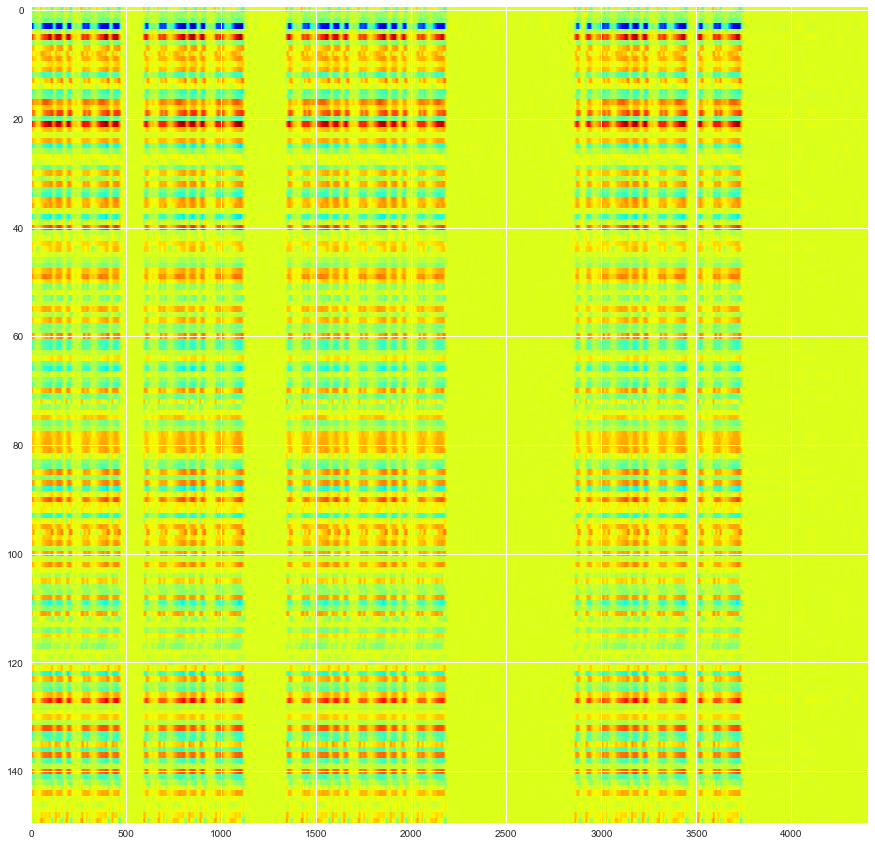

In [27]:
plt.figure(figsize=(15,15))
plt.imshow(firings_all, cmap='jet', aspect='auto')
plt.savefig('image.pdf')

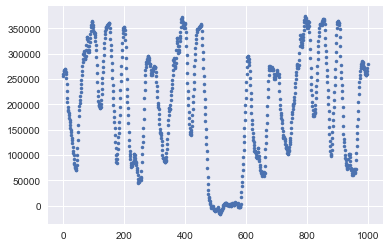

In [24]:
plt.plot(firings_all[9,:1000], '.')

In [ ]:
strfs_all.shape

In [ ]:
plt.plot(strfs_all[0,:])

In [ ]:
# Read song
fs, song = scipy.io.wavfile.read('./Finch_songs/2017BBLB1_42968.51352408_8_21_14_15_52.wav')

# Read strfs
strfs_all = np.genfromtxt('./STRFs/STRFarr_finch_kail_150_neurons_171010.csv', delimiter=',')
# Remove first column (index)
strfs_all = strfs_all[:,1:]

# Read the pca parameters
f = open('./pca_finch_kail_150neurons_200pcs.pckl', 'rb')
pca = pickle.load(f)
f.close()

In [ ]:
def reconstruct_from_A_s(A, S, pca, shape, segment_width, segment_len, Y=None):
    '''Reconstruct the spectrogram, given a dictionary A of receptive fields,
    and s: the activity of neurons'''
    Y = np.dot(A, S)
    Y_inverted = pca.inverse_transform(Y.T).T
    recons = np.zeros(shape)

    for ncol in range(Y.shape[1]):
        segment = np.reshape(Y_inverted[:,ncol], (segment_width, segment_len))
        start = ncol * segment_step
        recons[:,start:(start + segment_len)] += segment
    return recons

def reconstruct_from_pca(Y, pca, shape, segment_width, segment_len):
    '''Reconstruct the spectrogram, given its pca projection'''
    recons = np.zeros(shape)
    Y_inverted = pca.inverse_transform(Y.T).T
    #Y_inverted = np.dot(comp.T, Y)
    for ncol in range(Y.shape[1]):
        segment = np.reshape(Y_inverted[:,ncol], (segment_width, segment_len))
        start = ncol * segment_step
        recons[:,start:(start + segment_len)] += segment
    return recons

def make_single_strf(A, index, pca_used, segment_width, segment_len):
    '''Make the strf from a dictionary A's column given by index '''
    A_col = A[index,:]
    #A_col_inv = pca_used.inverse_transform(A_col)
    A_inv_im = np.reshape(A_col, (segment_width, segment_len))
    A_inv_im /= np.max(np.abs(A_inv_im))

    # Invert if skew is negative
    skew = scipy.stats.skew(A_inv_im.ravel())
    if skew < 0:
        A_inv_im *= -1
    
    return A_inv_im

def make_all_strfs(A, segment_width, segment_len):
    '''Make the strf from a dictionary A's column given by index '''
    A_col = A[index,:]
    #A_col_inv = pca_used.inverse_transform(A_col)
    A_inv_im = np.reshape(A_col, (segment_width, segment_len))
    A_inv_im /= np.max(np.abs(A_inv_im))

    # Invert if skew is negative
    skew = scipy.stats.skew(A_inv_im.ravel())
    if skew < 0:
        A_inv_im *= -1
    
    return A_inv_im

In [ ]:
strfs_all.shape

In [ ]:
s = make_single_strf(strfs_all, 0, pca, 256, 22)
plt.imshow(np.flipud(s), cmap = 'jet')

In [ ]:
nrows = 10
ncols = 15
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols,2 * nrows))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
            wspace=None, hspace=None)
for i in range(nrows):
    for j in range(ncols):
        A_inv_im = make_single_strf(strfs_all, ncols * i + j, pca, 256, 22)      
        ax[i][j].grid(False)
        ax[i][j].imshow(np.flipud(A_inv_im), cmap='jet', aspect='auto', extent=[0, 200, 100, 4000])
        ax[i][j].set_ylim([100, 4000])
        if i != nrows - 1 or j != 0:
            ax[i][j].set(xticklabels=[], yticklabels=[])
        else:
            ax[i][j].set_xlabel('Time (ms)')
            ax[i][j].set_ylabel('Frequency (Hz)')
            ax[i][j].yaxis.set_major_locator(plt.FixedLocator([100, 4000]))
            #ax[i][j].yaxis.set_major_formatter(plt.FuncFormatter(format_func_pcs)) 

In [ ]:
def multitaper_spec(X, fs, nadvance=100, slepian_len=500, nperseg=4096*4, NW=1):
    '''Perform a dpss multitapering
    Returns the spectrogram, frequency (f) and time ticks (t)'''

    # Use slepian window of width 0.3
    #window = scipy.signal.slepian(M=slepian_len, width=NW / slepian_len)
    window = scipy.signal.blackman(slepian_len)
    window = np.lib.pad(window, (0, nperseg - slepian_len), 'constant', constant_values=(0, 0))
    noverlap = len(window) - nadvance

    f,t,spectrogram = scipy.signal.spectrogram(X, fs, window=window, noverlap=noverlap)
    spectrogram = 20 * np.log10(spectrogram) #Units: dB
    
    return (f, t, spectrogram)

def sample_logspec(spectrogram, f, nsamples=256, fmin=100.0, fmax=4000.0):
    '''Sample the spectrogram to collect the required number of samples
    in frequency from fmin to fmax, logarithmically spaced
    Returns the spectrogram and the frequencies sampled'''
    # Frequencies to sample
    spacing = (np.log(fmax) - np.log(fmin)) / (nsamples - 1)
    logfreqs = np.log(fmin) + np.arange(nsamples) * spacing
    freqs = np.exp(logfreqs)
    
    # Sampled version
    row_ids = []
    for freq in freqs:
        row_ids.append(len(f[f < freq]))

    logspec = spectrogram[row_ids,:]
    return (logspec, freqs)

def format_func_spec(value, tick_number):
    '''Format tick marks for spectrogram plot'''
    if value >= len(freqs):
        label = max(freqs)
    else:
        label = freqs[int(value)]
    return int(np.round(label, -2))

def format_func_pcs(value, tick_number):
    '''Formatting axis ticks for the PC plot'''
    return value

In [ ]:
# Compute the spectrogram and log spectrogram
f,t,spectrogram = multitaper_spec(song, fs=fs, nadvance=100, nperseg=4096*4)

In [ ]:
logspec, freqs = sample_logspec(spectrogram, f, fmin=300.0, fmax=15000)

In [ ]:
plt.plot(song[340000:360000])

In [ ]:
plt.hist(song)

In [ ]:
plt.hist(logspec.ravel())

In [ ]:
# Time and frequency ranges for plotting
fmin = 0
fmax = np.max(f) #Hz
tmin = 0
tmax = max(t) #s
f_start = len(f[f<fmin])
f_end = len(f[f<fmax])
t_start = len(t[t<tmin])
t_end = len(t[t<tmax])


# Plot the spectrogram and log spectrogram
fig, ax = plt.subplots(2, 1, figsize=(20,10))
ax[0].imshow(np.flipud(spectrogram[f_start:f_end,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, fmin, fmax])
ax[0].grid(False)
ax[0].set_title('Song spectrogram', fontsize=20)
ax[0].set_xlabel('Time (s)', fontsize=20)
ax[0].set_ylabel('Frequency (Hz)', fontsize=20);
ax[0].tick_params(axis='both', which='major', labelsize=20)

# For plotting
ax[1].imshow(np.flipud(logspec[:,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, 0, len(freqs)])
ax[1].grid(False)
ax[1].set_title('Song spectrogram, log sampled', fontsize=20)
ax[1].set_xlabel('Time (s)', fontsize=20)
ax[1].set_ylabel('Frequency (Hz)', fontsize=20);
ax[1].yaxis.set_major_formatter(plt.FuncFormatter(format_func_spec))
ax[1].tick_params(axis='both', which='major', labelsize=20)

In [ ]:
nadvance = 100
n_comp_pca = 200
segment_len_ms = 50
segment_len = int(segment_len_ms / 1000 / nadvance * fs) #samples
spectrogram = logspec
segment_width = spectrogram.shape[0]
segment_step = int(segment_len / 10) #samples
dt = segment_len * nadvance / fs * 1000 #length of each window in ms
segments_lst = []
for t_start in np.arange(0, spectrogram.shape[1] - segment_len, segment_step):
    segments_lst.append(spectrogram[:,t_start:(t_start + segment_len)])

In [ ]:
reconstruct_from_pca?

In [ ]:
Y2 = pca.transform(X1.T).T 

In [ ]:
X_recons = reconstruct_from_pca(Y2, pca, logspec.shape, 256, 22)

In [ ]:
# Do pca on each segment
X = np.zeros((segments_lst[0].shape[0] * segments_lst[0].shape[1], len(segments_lst)))
for idx, segment in enumerate(segments_lst):
    X[:,idx] = segment.ravel()    

# Mean subtract
Xmean = np.mean(X, axis=1)
Xmeans = np.tile(Xmean, (X.shape[1], 1))
X1 = X - Xmeans.T

# Perform pca with whitening
#pca = PCA(n_components=n_comp_pca, whiten=True)
#pca.fit(X1.T)
Y = pca.transform(X1.T).T 
print('        Number of segments:', Y.shape[1])

## Perform the convolution

In [ ]:
firings_all = np.zeros(0)
for i in range(strfs_all.shape[1]):
    A_inv_im = make_single_strf(strfs_all, i, pca, 256, 22)
    firing = scipy.signal.convolve2d(X_recons, A_inv_im, mode='valid').ravel()
    #firing -= np.mean(firing)
    firings_all = np.concatenate((firings_all, firing.T))

In [ ]:
firings_all = firings_all.reshape(strfs_all.shape[1], len(firing))

In [ ]:
plt.plot(firings_all[10,:1000])

In [ ]:
plt.imshow(firings_all, aspect='auto', cmap='hot')
plt.grid(False)

In [ ]:
plt.plot(firings_all[0,:])

In [ ]:
s = scipy.signal.convolve2d(logspec, A_inv_im, mode='valid')

In [ ]:
s.shape

In [ ]:
plt.plot(s.ravel())

In [ ]:
s = scipy.signal.convolve2d(logspec, A_inv_im, mode='valid')